In [ ]:
!pip install tensorflow==2.16.0rc0
!pip install segmentation_models_3D
!PYTHONHASHSEED=0

In [ ]:
# Import other modules
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import random as python_random
import os

# Import TensorFlow/Keras
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, Conv3DTranspose, MaxPooling3D, concatenate, Dropout, Activation, BatchNormalization, GroupNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Percorso del file ZIP su Google Drive
# drive_zip_path = '/content/gdrive/MyDrive/DL_PROJECT/'
# Local path
local_zip_path = '/content/gdrive/MyDrive/DL_PROJECT/Data/128.zip'


In [ ]:
local_extract_path = '/content/Training_Data'
os.makedirs(local_extract_path, exist_ok=True)


In [ ]:
# Decomprimere il file ZIP nella directory locale
with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
    zip_ref.extractall(local_extract_path)

print("Decompressione completata.")

Decompressione completata.


### Defining Data Generator

In [ ]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):

            image = np.load(img_dir + image_name)

            images.append(image)

    images = np.array(images)

    return images

In [ ]:
def image_loader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:

            limit = min(L, batch_end)

            img = load_img(img_dir, img_list[batch_start:limit])
            mask = load_img(mask_dir, mask_list[batch_start:limit])

            yield(img, mask)

        batch_start += batch_size
        batch_end += batch_size


#### Testing data generator

In [ ]:
from matplotlib import pyplot as plt
import random

In [ ]:
train_img_dir = "/content/Training_Data/X_train/"
train_mask_dir = "/content/Training_Data/Y_train/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

In [ ]:
batch_size = 4

In [ ]:
train_img_datagen = image_loader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)

In [ ]:
img, mask = train_img_datagen.__next__()

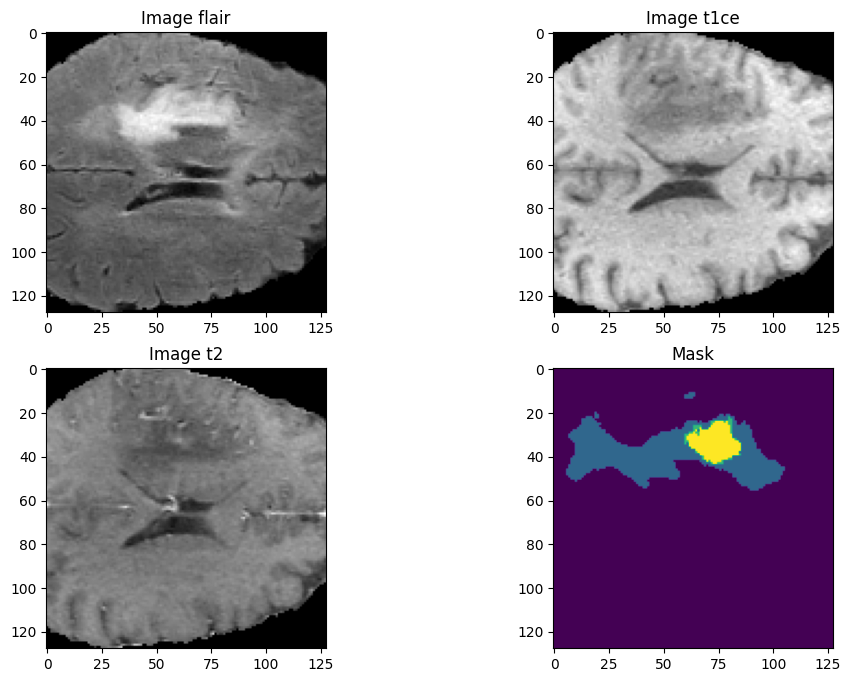

In [ ]:
img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=mask[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

### Loss, Metrics, optimizer etc..

In [ ]:
import pandas as pd
import glob

In [ ]:
### COUNT OF WEIGTHS
columns = ['0','1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('/content/Training_Data/Y_train/*.npy'))
for img in range(len(train_mask_list)):

  #print(img)
  temp_image=np.load(train_mask_list[img])
  temp_image = np.argmax(temp_image, axis=3)
  val, counts = np.unique(temp_image, return_counts=True)

  conts_dict = {str(i): 0 for i in range(4)}
  for v, c in zip(val, counts):
    conts_dict[str(v)] = c

  row_df = pd.DataFrame([conts_dict])

  # Uso di pd.concat per aggiungere la nuova riga
  df = pd.concat([df, row_df], ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['2'].sum()
label_3 = df['3'].sum()

total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4

wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)

print(wt0, wt1, wt2, wt3)

0.26 8.56 29.69 27.28


In [ ]:
import tensorflow.keras.backend as K

def DiceCoefficient(y_true, y_pred, smooth = 1e-6):

    y_pred = tf.keras.activations.softmax(y_pred, axis = -1)

    # Cast to float32 datatype
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    # Flatten label and prediction tensors
    inputs = K.flatten(y_pred)
    targets = K.flatten(y_true)

    intersection = K.sum(inputs * targets)
    dice = (2 * intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return dice

In [ ]:
CFC_loss = keras.losses.CategoricalFocalCrossentropy(alpha = [wt0, wt1, wt2, wt3])


In [ ]:
IoU_0 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [0])
IoU_1 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [1])
IoU_2 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [2])
IoU_3 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [3])

Mean_IoU = keras.metrics.OneHotMeanIoU(num_classes = 4)

metrics = ["accuracy", DiceCoefficient, Mean_IoU, IoU_0, IoU_1, IoU_2, IoU_3]

In [ ]:
train_img_dir = "/content/Training_Data/X_train/"
train_mask_dir = "/content/Training_Data/Y_train/"
train_img_list= sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

In [ ]:
val_img_dir = "/content/Training_Data/X_val/"
val_mask_dir = "/content/Training_Data/Y_val/"
val_img_list= sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

In [ ]:
batch_size = 4

train_img_dir = "/content/Training_Data/X_train/"
train_mask_dir = "/content/Training_Data/Y_train/"
train_img_list= sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

print(steps_per_epoch, val_steps_per_epoch)

84 18


In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 1e-3,
    decay_steps  = (len(train_img_list) // batch_size),
    decay_rate = 0.95)

optim = keras.optimizers.Adam(learning_rate = lr_schedule)

### DEFINE MODEL ARCHITECTURE - 3D U-Net

In [ ]:
def conv_block(input, n_filters, dropout_rate):

    x = Conv3D(n_filters, 3, padding='same')(input)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    x = Conv3D(n_filters, 3, padding='same')(x)
    x = Activation('relu')(x)

    return x

def encoder_block(input, num_filters, dropout_rate):

    x = conv_block(input, num_filters, dropout_rate)
    p = MaxPooling3D((2, 2, 2))(x)

    return x, p

def decoder_block(input, skip_features, num_filters, dropout_rate):

    x = Conv3DTranspose(num_filters, (2, 2, 2), strides=(2, 2, 2), padding='same')(input)
    x = concatenate([x, skip_features])
    x = conv_block(x, num_filters, dropout_rate)

    return x

In [ ]:
def build_unet(input_shape, n_classes, num_filters):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, num_filters, 0.1)
    s2, p2 = encoder_block(p1, 2*num_filters, 0.1)
    s3, p3 = encoder_block(p2, 4*num_filters, 0.2)
    s4, p4 = encoder_block(p3, 8*num_filters, 0.2)

    b1 = conv_block(p4, 16*num_filters, 0.3)

    d1 = decoder_block(b1, s4, 8*num_filters, 0.2)
    d2 = decoder_block(d1, s3, 4*num_filters, 0.2)
    d3 = decoder_block(d2, s2, 2*num_filters, 0.1)
    d4 = decoder_block(d3, s1, num_filters, 0.1)

    outputs = Conv3D(n_classes, 1, padding = 'same', activation='softmax')(d4)

    model = Model(inputs, outputs, name='3D_U-Net')
    return model

input_shape = (128, 128, 128, 4)
n_classes = 4

model = build_unet(input_shape, n_classes, 32)
model.compile(optimizer = optim, loss = CFC_loss, metrics = metrics)
model.summary()

Model: "3D_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 128,  │              0 │ -                      │
│ (InputLayer)              │ 4)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 128, 128, 128,  │          3,488 │ input_layer_1[0][0]    │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 128,  │              0 │ conv3d[0][0]           │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 128,  │              0 │ activation[0][0]       │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 128, 128, 128,  │         27,680 │ dropout[0][0]          │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 128,  │              0 │ conv3d_1[0][0]         │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d             │ (None, 64, 64, 64, 32) │              0 │ activation_1[0][0]     │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2 (Conv3D)         │ (None, 64, 64, 64, 64) │         55,360 │ max_pooling3d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 64, 64) │              0 │ conv3d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 64, 64) │              0 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3 (Conv3D)         │ (None, 64, 64, 64, 64) │        110,656 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 64, 64) │              0 │ conv3d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_1           │ (None, 32, 32, 32, 64) │              0 │ activation_3[0][0]     │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_4 (Conv3D)         │ (None, 32, 32, 32,     │        221,312 │ max_pooling3d_1[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 32, 32, 32,     │              0 │ conv3d_4[0][0]         │
│                      

 Total params: 22,578,020 (86.13 MB)

 Trainable params: 22,578,020 (86.13 MB)

 Non-trainable params: 0 (0.00 B)

### **Compile and fit**

In [ ]:
# Callback per salvare il miglior modello basato sulla loss di validazione
checkpoint_path = "/content/gdrive/MyDrive/DL_PROJECT/3D_Unet_first.h5.keras"

checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_best_only = True,
    monitor = 'val_loss',
    mode = 'min',
    verbose = 1
)
early_stopping_callback = EarlyStopping(
    monitor = 'val_loss',    # Monitorare la loss di validazione
    patience = 10,           # Numero di epoche con nessun miglioramento dopo le quali l'addestramento verrà fermato
    restore_best_weights = True # Ripristina i pesi del miglior modello visto durante l'addestramento
  )

csv = keras.callbacks.CSVLogger("/content/gdrive/MyDrive/DL_PROJECT/hist_3D_first", separator=",", append = False)

In [ ]:
batch_size = 4

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

print(steps_per_epoch, val_steps_per_epoch)

84 18


In [ ]:
train_img_dir = "/content/Training_Data/X_train/"
train_mask_dir = "/content/Training_Data/Y_train/"
train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

In [ ]:
val_img_dir = "/content/Training_Data/X_val/"
val_mask_dir = "/content/Training_Data/Y_val/"
val_img_list = sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

In [ ]:
train_mask_list

In [ ]:
train_img_datagen = image_loader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)

In [ ]:
val_img_datagen = image_loader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

In [ ]:
history=model.fit(train_img_datagen,
                  steps_per_epoch=steps_per_epoch,
                  epochs=20,
                  verbose=1,
                  validation_data=val_img_datagen,
                  validation_steps=val_steps_per_epoch,
                  callbacks = [checkpoint_callback, early_stopping_callback, csv]
)


Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.4651 - dice_coefficient: 0.2837 - loss: 0.4998 - one_hot_io_u_4: 0.2737 - one_hot_io_u_5: 0.2235 - one_hot_io_u_6: 0.0440 - one_hot_io_u_7: 0.0718 - one_hot_mean_io_u_1: 0.1532
Epoch 1: val_loss improved from inf to 0.74864, saving model to /content/gdrive/MyDrive/DL_PROJECT/3D_Unet_first.h5.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 115s 636ms/step - accuracy: 0.4652 - dice_coefficient: 0.2838 - loss: 0.4991 - one_hot_io_u_4: 0.2733 - one_hot_io_u_5: 0.2252 - one_hot_io_u_6: 0.0444 - one_hot_io_u_7: 0.0726 - one_hot_mean_io_u_1: 0.1539 - val_accuracy: 0.4845 - val_dice_coefficient: 0.3128 - val_loss: 0.7486 - val_one_hot_io_u_4: 0.3685 - val_one_hot_io_u_5: 0.1217 - val_one_hot_io_u_6: 0.1219 - val_one_hot_io_u_7: 0.0441 - val_one_hot_mean_io_u_1: 0.1640
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.6212 - dice_coefficient: 0.3403 - loss: 0.2511 - one_hot_io_u_4: 0.2898 - one_hot_io_u_5: 0.3312 - one_hot_io_u_

In [ ]:
Unet_3D.save("/content/gdrive/MyDrive/DL_PROJECT/3_D_first.keras")

In [ ]:
Unet_3D.save_weights("/content/gdrive/MyDrive/DL_PROJECT/3_D_first.weights.h5", overwrite=True)

In [ ]:
history.history["loss"]

[0.6644736528396606,
 0.4024335741996765,
 0.36886489391326904,
 0.20986153185367584,
 0.14535319805145264,
 0.117879718542099,
 0.10033826529979706,
 0.09052959829568863,
 0.082192562520504,
 0.0761675089597702,
 0.07104619592428207,
 0.06673113256692886,
 0.06312098354101181,
 0.05999668315052986,
 0.05828843638300896,
 0.05564132332801819,
 0.05367012694478035,
 0.05188097804784775,
 0.05000683665275574,
 0.0489419586956501]

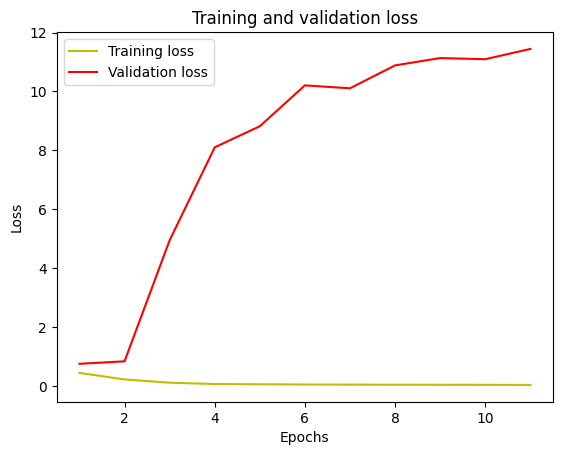

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

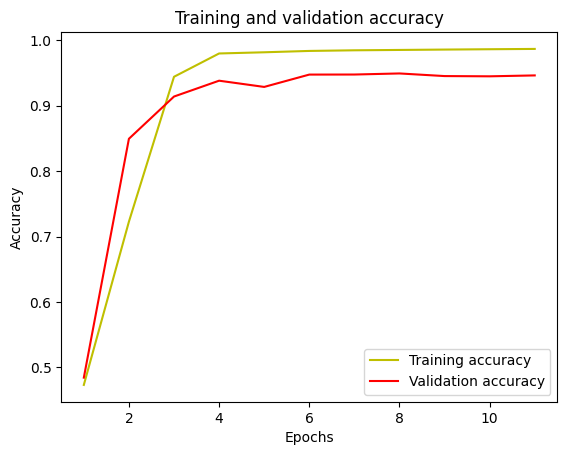

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'dice_coefficient', 'loss', 'one_hot_io_u_4', 'one_hot_io_u_5', 'one_hot_io_u_6', 'one_hot_io_u_7', 'one_hot_mean_io_u_1', 'val_accuracy', 'val_dice_coefficient', 'val_loss', 'val_one_hot_io_u_4', 'val_one_hot_io_u_5', 'val_one_hot_io_u_6', 'val_one_hot_io_u_7', 'val_one_hot_mean_io_u_1'])

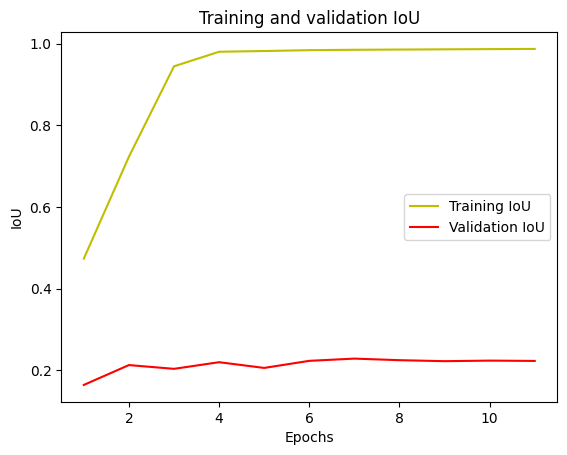

In [ ]:
history.history['one_hot_mean_io_u_1']
val_acc = history.history['val_one_hot_mean_io_u_1']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 1e-3,
    decay_steps  = (len(train_img_list) // batch_size),
    decay_rate = 0.95)

optim = keras.optimizers.Adam(learning_rate = lr_schedule)

In [ ]:
def build_unet(input_shape, n_classes, num_filters):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, num_filters, 0.3)
    s2, p2 = encoder_block(p1, 2*num_filters, 0.3)
    s3, p3 = encoder_block(p2, 4*num_filters, 0.3)

    b1 = conv_block(p3, 8*num_filters, 0.3)

    d1 = decoder_block(b1, s3, 4*num_filters, 0.3)
    d2 = decoder_block(d1, s2, 2*num_filters, 0.3)
    d3 = decoder_block(d2, s1, num_filters, 0.3)

    outputs = Conv3D(n_classes, 1, padding = 'same', activation='softmax')(d3)

    model = Model(inputs, outputs, name='3D_U-Net')
    return model

input_shape = (128, 128, 128, 4)
n_classes = 4

model_2 = build_unet(input_shape, n_classes, 16)
model_2.compile(optimizer = optim, loss = CFC_loss, metrics = metrics)
model_2.summary()

Model: "3D_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 128,  │              0 │ -                      │
│ (InputLayer)              │ 4)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_19 (Conv3D)        │ (None, 128, 128, 128,  │          1,744 │ input_layer_2[0][0]    │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 128, 128, 128,  │              0 │ conv3d_19[0][0]        │
│ (Activation)              │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 128, 128, 128,  │              0 │ activation_18[0][0]    │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_20 (Conv3D)        │ (None, 128, 128, 128,  │          6,928 │ dropout_9[0][0]        │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 128, 128, 128,  │              0 │ conv3d_20[0][0]        │
│ (Activation)              │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_4           │ (None, 64, 64, 64, 16) │              0 │ activation_19[0][0]    │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_21 (Conv3D)        │ (None, 64, 64, 64, 32) │         13,856 │ max_pooling3d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 64, 64, 64, 32) │              0 │ conv3d_21[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 64, 64, 64, 32) │              0 │ activation_20[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_22 (Conv3D)        │ (None, 64, 64, 64, 32) │         27,680 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_21             │ (None, 64, 64, 64, 32) │              0 │ conv3d_22[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_5           │ (None, 32, 32, 32, 32) │              0 │ activation_21[0][0]    │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_23 (Conv3D)        │ (None, 32, 32, 32, 64) │         55,360 │ max_pooling3d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_22        

 Total params: 1,401,908 (5.35 MB)

 Trainable params: 1,401,908 (5.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_2=model_2.fit(train_img_datagen,
                  steps_per_epoch=steps_per_epoch,
                  epochs=20,
                  verbose=1,
                  validation_data=val_img_datagen,
                  validation_steps=val_steps_per_epoch,
                  callbacks = [checkpoint_callback, early_stopping_callback, csv]
)

Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.5852 - dice_coefficient: 0.3073 - loss: 0.4728 - one_hot_io_u: 0.3054 - one_hot_io_u_1: 0.2315 - one_hot_io_u_2: 0.0334 - one_hot_io_u_3: 0.0665 - one_hot_mean_io_u: 0.1592
Epoch 1: val_loss improved from inf to 1.23937, saving model to /content/gdrive/MyDrive/DL_PROJECT/3D_Unet_first.h5.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 80s 491ms/step - accuracy: 0.5858 - dice_coefficient: 0.3077 - loss: 0.4716 - one_hot_io_u: 0.3046 - one_hot_io_u_1: 0.2334 - one_hot_io_u_2: 0.0338 - one_hot_io_u_3: 0.0673 - one_hot_mean_io_u: 0.1598 - val_accuracy: 0.8609 - val_dice_coefficient: 0.3746 - val_loss: 1.2394 - val_one_hot_io_u: 0.4884 - val_one_hot_io_u_1: 0.1250 - val_one_hot_io_u_2: 0.0313 - val_one_hot_io_u_3: 0.0707 - val_one_hot_mean_io_u: 0.1788
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.8384 - dice_coefficient: 0.4026 - loss: 0.2051 - one_hot_io_u: 0.3528 - one_hot_io_u_1: 0.3759 - one_hot_io_u_2: 0.0897 - one